# Additional Resources of *Chebfun2* implementation

## Default Structure 

$$f_{app}(x,y) = (\vec{v}^T \mathbf{W} \vec{u}) (x,y)$$

### Gauss elmination with complete pivoting for function

Machine epsilon: 
    
    * float: 5E-7
    * double 5E-16

* **Input** : A function $f = f(x,y)$ on $[-1, 1]^2$ and a tolerance *tol*.


* **Output** : A low rank approximation $f_k(x,y)$ satisfying $|f - f_k| <$ *tol*.

* **Initial Setting**

    * $e_0(x,y) = f(x,y), f_0 (x,y) = 0 $

* **for** $k = 0, 1, 2 \dots$,

    * $|e_k(x_k, y_k)| = \text{max}(|e_k(x,y)|), (x,y) \in [-1, 1]^2$
    * **if** $|e_k (x_k, y_k)| <$ **tol**, **stop**.
    * $e_{k+1}(x,y) = e_k (x,y) - e_k(x_k, y) e_k(x, y_k)/ e_k(x_k, y_k)$
    * $f_{k+1}(x,y) = f_k(x,y) + e_k(x_k, y) e_k(x, y_k)/e_k(x_k, y_k)$
* **end**


#### Basis with 2dim weight matrix for accelerating calculation

Let 

$$e_k (x,y) = f(x,y) + (\vec{v}^T_k \mathbf{W}_k \vec{u}_k)(x,y)$$

where, $\vec{v}_k, \vec{u}_k \in \mathcal{F}^k, \mathbf{W}_k \in \mathbf{M}_{k \times k}(\mathbb{R})$ and 

$$\vec{u}_k = [u_1, u_2, u_3, \dots, u_k]^T, u_i(x)$$
$$\vec{v}_k = [v_1, v_2, v_3, \dots, v_k], v_i(y)$$
$$\mathbf{W}_k = \begin{bmatrix} 
    w_{11} & w_{12} & \cdots & w_{1k} \\
    w_{21} & w_{22} & \cdots & w_{2k} \\
    \vdots& \vdots & \ddots & \vdots \\
    w_{k1} & w_{k2} & \cdots & w_{kk}
\end{bmatrix}$$

Now $k+1$ term is,

$$e_{k+1}(x, y) = e_k(x, y) - \frac{e_k(x, y_k) e_k(x_k, y)}{e_k(x_k, y_k)}$$
$$= (f + \vec{v}^T_k \mathbf{W}_k \vec{u}_k) + d_k \left( \left(f(x, y_k) + \vec{v}^T_k (y_k )\mathbf{W}_k \vec{u}_k \right) \left(f(x_k, y) + \vec{v}^T_k \mathbf{W}_k \vec{u}_k(x_k)\right) \right)$$

the last term can be expanded as 

$$d_k \left( \left(f(x, y_k) + \vec{v}^T_k (y_k )\mathbf{W}_k \vec{u}_k \right) \left(f(x_k, y) + \vec{v}^T_k \mathbf{W}_k \vec{u}_k(x_k)\right) \right)$$

$$ = d_k \left( f(x, y_k) + \sum_i^k {\lambda}_{i} u_i\right) \left( f(x_k, y) + \sum_i^k \mu_{i} v_i \right)$$

$$\lambda_i = \sum_j^k v_j(y_k) w_{ij}$$
$$\mu_i = \sum_j^k u_j(x_k) w_{ji}$$

let $u_{k+1}(x) = f(x, y_k), v_{k+1}(y) = f(x_k, y)$ 

$$ = d_k \left( \sum_i^{k+1} \sum_j^{k+1} dw_{ij} u_i(x) v_j(y) \right)$$


$$\mathbf{W}_{k+1} = \text{pad}(\mathbf{W}_k) + \mathbf{dW}_k$$

$$\text{pad}(\mathbf{W}_k) = \begin{bmatrix} 
        \mathbf{W}_k & \vec{0}^t\\
        \vec{0} & 0 
    \end{bmatrix}$$
$$\mathbf{dW}_k = d_k([\lambda_1, \lambda_2, \dots, \lambda_k, 1]*[\mu_1, \mu_2, \dots, \mu_k, 1]) $$

---

## Calculation GE on Chebyshev grid

Above formula indicating vector consist of function elements, and you can achieve enough speed for calculation of under 100 rank approximation. 
However, you don't have to do the full elimination process with function elements, the only things we needs are grid point values. This process is implemented as `completeACA` function of `chebfun/@chebfun2/constructor.m` file.

Let $\mathbf{P}_{n,m}  = \{p_{ij}=(x_i, y_j) | i = 0, 1, \dots n, j = 0, 1, \dots, m\}, \mathbf{P}_{n,m} \in \mathcal{M}_{n \times m}$ are the grid point on domain $[a, b]\times[c, d]$

$$\mathbf{F}_0 = f(\mathbf{P}_{n,m}) \in \mathcal{M}_{n \times m}$$

$$\mathbf{F}_{n+1} = \mathbf{F}_n - (\mathbf{F}_{, k} *_{conv} \mathbf{F}_{l, })/ \mathbf{F}_{l, k}$$
$$\mathbf{F}_{, k} = \begin{bmatrix} f_{1, k}, f_{2, k} \dots f_{n, k }\end{bmatrix}^T$$
$$\mathbf{F}_{l, } = \begin{bmatrix} f_{l, 1}, f_{l, 2} \dots f_{l, m}\end{bmatrix}$$

**Note**: Using matrix multiplication in convolution calculation.

$\mathbf{F}_{, k} *_{conv} \mathbf{F}_{l, }$ is a $R^{n} \times R^{m} \rightarrow R^{nm}$, however, padding two vector to $R^{nm}$ dim matrix and matrix multiplication is faster more than 800 times than ordinary 2dim convolution. It requires more space in memory but profit in time is huge.


In [305]:
i, j = 3, 4
def row_col_convolve(i, j, A):
    row_vec = A[i, :].reshape(1, -1)
    col_vec = A[:, j].reshape(-1, 1)
    return convolve2d(row_vec, col_vec)

In [306]:
def row_col_mul(i, j, A):
    nx, ny = A.shape
    row_vec = np.tile(A[i, :], (nx, 1))
    col_vec = np.tile(A[:, j], (ny, 1)).T
    return row_vec * col_vec

In [307]:
A.shape

(513, 513)

In [308]:
%%timeit -n 100 -r 3
dA = row_col_convolve(i,j, A)

478 ms ± 457 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


In [309]:
%%timeit -n 100 -r 3
dA = row_col_mul(i, j ,A)

549 µs ± 66.4 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


In [310]:
478E-3/549E-6

870.6739526411657

## Some tips

When you write complicated function class on python, 
it is recommanded that reducing function call as smaller as possible
See above, "Additional Detail" part, we can eliminate duplicated function 
calls by increasing a dimension of "weight" value from 1 dim vector to 2 dim matrix. 
You can directly implement, GE approximation function class in 

```.py
u_x = np.fromiter( (u(x) for u in func_x) )
v_y = np.fromiter( (v(y) for v in func_y))
v_y * w * u_x
``` 

form with properties that
two callable arrays, u, v, and weight array. It will work fine but after 30 rank
of function it will show poor efficiency in mesh grid calculation. 



### Accelerating numpy calculation.

Think about a situation that you only need specific part of the matrix after calculation, such as `trace`, `diagonal` or et cetra. In this time assump that you need only diagnoal elements of the result matrix. You can directly calculate the result matrix and extract those valeus. It will be fine in low dimension. 

```
np.diag(x.T @ W @ y)
```

However, if `x, y, W` dimensions are huge, there are lot of inefficiency of resources not only for spatial but also for calculation time. The non-diagonal terms are not needed in this case. In this case, you can use [*einsum* module](https://numpy.org/doc/stable/reference/generated/numpy.einsum.html) of *numpy*. It is a general tensor summation and representation implementaion module. Many tensor based lbiraries such as Pytorch, Numpy, TensorFlow supports *einsum* module. The term *ein* means a Albert Einstein's, being popular with relativity theories, tensor notation.  

```
np.einsum("ji,jk,ki->i",fy_v, weight, fx_v)
```

if you want accelerating total speed of numpy library, then see [Jax](https://github.com/google/jax) project. 
  


### Tolerance calculation

From `chebfun/@chebfun2/constructor.m` on repository.

    % Calculate a tolerance and find numerical rank to this tolerance:
    % The tolerance assumes the samples are from a function. It depends
    % on the size of the sample matrix, hscale of domain, vscale of
    % the samples, condition number of the function, and the accuracy
    % target in chebfun2 preferences.
    ...
    % It is based on a finite difference approximation to the gradient, the size of the approximation domain, the internal working tolerance, and an arbitrary (2/3) exponent.

For $n, m$ grid sample, and $eps$, epsilon,  

$${tol}_{rel} = \max(n,m) \cdot eps $$
$$tol_{abs} = size(domain) \max(f, df_x, df_y) \cdot tol_{rel}$$

Phase 1, break tolerance = $tol_{abs}$

$\mathbb{P} = \{p_{ij} = (x_i, y_j)| i,j = 0, 1, 2, \dots\}$


## Implementation


### Phase 1

In [1]:
from typing import Iterable, Callable, Tuple, List
from numbers import Number

from functools import partial

import numpy as np
from numpy.polynomial import Chebyshev

from scipy.signal import convolve2d
from scipy.special import airy

from matplotlib import pyplot as plt

In [2]:
# From "An Extension of Chebfun to Two Dimensions", Figure 2.3
def func_test(x,y, t=0):
    if t == 0: 
        # There is an equation error on (a).
        # This is a correction version
        return 1/(1+100*(x**2-y**2)**2) 
    elif t == 1:
        return 1/(1+100*(1/2 -(x**2+y**2))**2)
    elif t ==2:
        return 1/(1+1000*((x**2-1/4)**2)*((y**2-1/4)**2))
    elif t ==3:
        return np.cos(10*(x**2 +y)) + np.sin(10*(x+y**2))
    elif t == 4:
        return airy(5*(x+y**2))[0] * airy(-5*(x**2 + y**2))[0]
    elif t == 5:
        return np.tanh(10*x)*np.tanh(10*y)/(np.tanh(10)**2) +np.cos(5*x)

In [3]:
# Basic Chebyshev routines
# cheby--------------------------------------
def cheby_range_transform(x, a, b): # [-1, 1] -> [a, b]
    return ((b-a)/2)*x + (b+a)/2
def cheby_range_inv_transform(x, a, b): # [a, b] -> [-1, 1]
    return (2/(b-a))*x - (b+a)/(b-a)
def cheby_ext_grid(a, b, n):
    x_i = np.cos((np.pi/n-1)*np.arange(n))
    return cheby_range_transform(x_i, a, b)
def cheby_root_grid(a, b, n):
    x_i = np.cos((np.pi/n)*(0.5+np.arange(n)))
    return cheby_range_transform(x_i, a, b)
#cheby ge----------------------------------
def cheby_stage_params(i):
    i+=1
    return int(2**(i+2) + 1), int(2**i +1)


In [4]:
func_t = lambda x,y: func_test(x,y, 0) # (a)

In [5]:
# Tolerance calculation 
def _get_tol(X, Y, vals, domain, pseudo_level):
        #Done
        nx, ny = vals.shape
        grid = max(nx, ny)
        dfdx = 0
        dfdy = 0

        if nx > 1 and ny >1 :
            dfdx = np.diff(vals[-1:, :], axis=1) / np.diff(X[:-1, :], axis=1)
            dfdy = np.diff(vals[:, :-1], axis=0) / np.diff(Y[:, :-1], axis=0)
        elif nx >1 and ny ==1:
            dfdx = np.diff(vals, axis=1) / np.diff(X, axis=1)
        elif nx == 1 and ny>1:
            dfdy = np.diff(vals, axis=0) / np.diff(Y, axis=0)
        
        jac_norm = np.max(np.maximum(np.abs(dfdx), np.abs(dfdy)))
        #print(jac_norm.max())
        vscale = np.max(np.abs(vals))
        #print(f"grid:{grid}, pseudo_level: {pseudo_level}")
        rel_tol = grid**(2/3) * pseudo_level
        abs_tol = np.max(np.abs(domain)) * max(jac_norm, vscale) * rel_tol
        return rel_tol, abs_tol

In [6]:
def aca_iter(A, px, py, i,j, max_iter, abs_tol):
    pivot_value = (A[i,j])
    pivot_position = px[i,j], py[i,j]
    # print(f"start, {pivot_value}")

    nx, ny = A.shape
    p_values = []
    p_position = []
    for k in range(0, max_iter):
        pivot_value = A[i,j]
        pivot_position = px[i,j], py[i,j]

        #print(100*" ", end="\r")
        #print(f"{k+1}/{max_iter}, {pivot_value}", end="\r")
        p_values.append(pivot_value)
        p_position.append(pivot_position)
        if np.abs(pivot_value) < abs_tol:
            break
        # It is convolution of row_i * col_j but
        # padding them and multiplication is 550 times more 
        # faster than convolution routine.
        # = convolution code =
        # row_vec = A[i, :].reshape(1, -1)
        # col_vec = A[:, j].reshape(-1, 1)
        # A = A - convolve2d(row_vec, col_vec)/pivot_value
        row_pad = np.tile(A[i, :], (nx, 1))
        col_pad = np.tile(A[:, j], (ny, 1)).T
        A = A - row_pad * col_pad/pivot_value

        e_k_val = np.abs(A)
        ind = np.argmax(e_k_val)
        i, j = divmod(ind, ny)

        #diagonal bias
        if ( ( nx == ny ) and ( np.max( np.abs( A.diagonal()  ) ) - pivot_value ) > -abs_tol ):
            ind = np.argmax(np.abs(A.diagonal()))
            i = j = ind
    
        
    return p_values, p_position, k+1, np.abs(pivot_value)

In [7]:
j = 5

x_i, x_f, y_i, y_f = domain = -1, 1, -1, 1
n, max_iter = cheby_stage_params(j)

cheby_deg = (n-1)
pivots = []
arr_x = cheby_root_grid(x_i, x_f, n)
arr_y = cheby_root_grid(y_i, y_f, n)
px, py = np.meshgrid(arr_x, arr_y)
_, c_l = px.shape

tol_err = {
    "float": 5E-7,
    "double": 5E-16
}
# new
A = func_test(px, py)
nx, ny = A.shape
width = min(nx, ny)
ind = np.argmax(np.abs(A))
i, j = divmod(ind, ny)
rel_tol, abs_tol = _get_tol(px, py, A, domain, tol_err["double"])

print(rel_tol, abs_tol)

2.0211199390385576e-14 2.6224116738879243e-13


In [8]:
%time
p_values, p_position, rank, eps = aca_iter(A, px, py, i,j, max_iter, abs_tol)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.1 µs


In [9]:
(rank, eps)

(65, 2.0060364311650516e-07)

In [10]:
p_values[0], p_values[-1]

(1.0, 2.0060364311650516e-07)

Text(0.5, 1.0, 'Error Decreasing of each steps in GE')

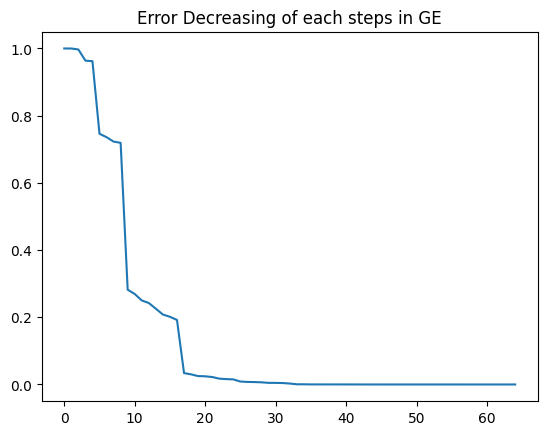

In [11]:
plt.plot(np.arange(len(p_values)), p_values)
plt.title("Error Decreasing of each steps in GE")

In [16]:
x_line = np.linspace(x_i, x_f, 300, endpoint=True)
y_line = np.linspace(y_i, y_f, 300, endpoint=True)
X, Y = np.meshgrid(x_line, y_line)
Z = func_test(X,Y)
ma, mi = Z.max(),  Z.min()
level_n = 10
level = np.linspace(mi, ma , level_n, endpoint=True)

Rank:65, Epsilon_abs: 2.0060364311650516e-07


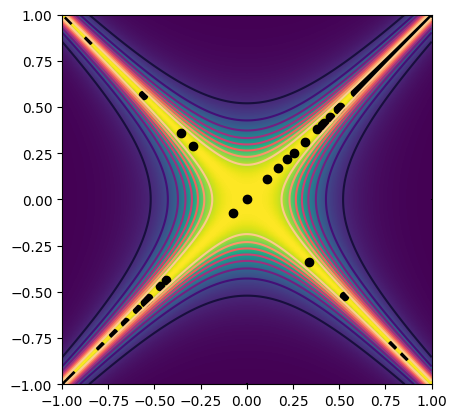

In [18]:
scatter = np.array(p_position).T
plt.imshow(func_test(X,Y), extent=(-1, 1, -1, 1))
plt.contour(X,Y,func_test(X,Y), level, cmap="magma")
plt.scatter(*scatter, c="black")
plt.axis('square')
print(f"Rank:{rank}, Epsilon_abs: {eps}")

Above plot seems different with paper figure, because the matlab implementation of *ChebFun2* has **digonal bias** in process of construction. The rank is same with Chebfun implementation on Matlab, 122, in the paper, 125.

In [19]:
def complete_aca(
        func: Callable,
        prime_rank:int,
        domain = [-1, 1, -1, 1],
        eps = [5E-16, 5E-16],
        factor = 4    
) -> Tuple[List[float], List[Tuple[float, float]], int, float]:

        x_i, x_f, y_i, y_f = domain = -1, 1, -1, 1
        n, max_iter = cheby_stage_params(prime_rank)

        #cheby_deg = (n-1)
        #pivots = []
        arr_x = cheby_root_grid(x_i, x_f, n)
        arr_y = cheby_root_grid(y_i, y_f, n)
        px, py = np.meshgrid(arr_x, arr_y)

        A = func(px, py)
        nx, ny = A.shape
        width = min(nx, ny)
        ifail = False

        ind = np.argmax(np.abs(A))
        i, j = divmod(ind, ny)
        rel_tol, abs_tol = _get_tol(px, py, A, domain, eps[0])

        pivot_value = (A[i,j])
        pivot_position = px[i,j], py[i,j]
        # print(f"start, {pivot_value}")

        nx, ny = A.shape
        p_values = []
        p_positions = []
        for k in range(0, max_iter):
                pivot_value = A[i,j]
                pivot_position = px[i,j], py[i,j]

                #print(100*" ", end="\r")
                #print(f"{k+1}/{max_iter}, {pivot_value}", end="\r")
                p_values.append(pivot_value)
                p_positions.append(pivot_position)
                if np.abs(pivot_value) < abs_tol:
                    break
                # It is convolution of row_i * col_j but
                # padding them and multiplication is 850 times more 
                # faster than convolution routine.
                # = convolution code =
                # row_vec = A[i, :].reshape(1, -1)
                # col_vec = A[:, j].reshape(-1, 1)
                # A = A - convolve2d(row_vec, col_vec)/pivot_value
                row_pad = np.tile(A[i, :], (nx, 1))
                col_pad = np.tile(A[:, j], (ny, 1)).T
                A = A - row_pad * col_pad/pivot_value
                
                # Next pivot
                e_k_val = np.abs(A)
                ind = np.argmax(e_k_val)
                i, j = divmod(ind, ny)

                #diagonal bias
                #if ( ( nx == ny ) and ( np.max( np.abs( A.diagonal()  ) ) - pivot_value ) > -abs_tol ):
                #    ind = np.argmax(np.abs(A.diagonal()))
                #    i = j = ind

        ifail = np.abs(pivot_value) <= abs_tol 
        ifail = np.abs(pivot_value) < width/factor and ifail
        
        return  p_values, p_positions, ifail


In [26]:
Z = func_t(X,Y)
ma, mi = Z.max(),  Z.min()
level_n = 10
level = np.linspace(mi, ma , level_n, endpoint=True)

In [27]:
p_value_list = []
p_positions_list = []
ifail_list = []
for i in range(0, 6):
    function_type = i
    func_ti = lambda x, y: func_test(x, y, function_type)
    prime_rank = 2
    domain = [-1, 1, -1, 1]
    eps_double = [5E-16, 5E-16] # double precision
    ifail = False
    while not ifail and prime_rank < 8:
        p_values, p_position, ifail = complete_aca(func_ti, prime_rank, domain, eps_double)
        prime_rank +=1
        
    p_value_list.append(p_values)
    p_positions_list.append(p_position)
    ifail_list.append(ifail)


In [30]:
name_fig = ["a", "b", "c", "d", "e", "f"]

In [32]:
xlin = np.linspace(-1,1,400)
ylin = np.linspace(-1,1,400)
X, Y = np.meshgrid(xlin, ylin)
level_n = 10

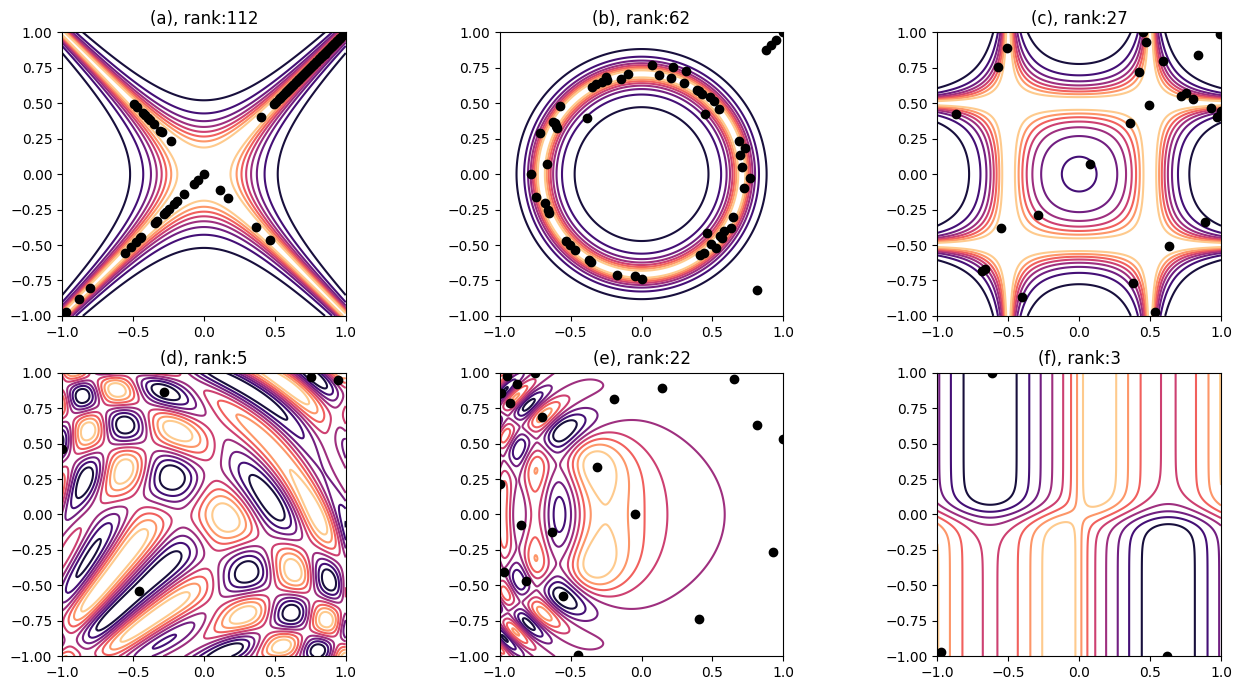

In [33]:
fig, axes = plt.subplots(2, 3, figsize = (16,16))
for i in range(0, 6):
    row, col = divmod(i, 3)
    Z = func_test(X, Y, i)

    ma, mi = Z.max(),  Z.min()
    
    level = np.linspace(mi, ma , level_n, endpoint=True)

    scatter = np.array(p_positions_list[i]).T

    ax = axes[row, col]

    ax.contour(X, Y, Z, level, cmap="magma", zorder=-1)
    ax.scatter(*scatter, c="black", zorder=1)
    ax.set_title(f"({name_fig[i]}), rank:{len(p_value_list[i])}")
    ax.axis("square")
fig.subplots_adjust(top=0.5)

Rank of the figure 2.3 of paper

1. Paper description:

|index|rank|index|rank|index|rank|
|:---:|:--:|:---:|:--:|:---:|:--:|
|(a)|125|(b)|65|(c)|28|
|(d)|5|(e)|33|(f)|2|

2. ChebFun2 Matlab implementation, v 5.7 (2017)

|index|rank|index|rank|index|rank|
|:---:|:--:|:---:|:--:|:---:|:--:|
|(a)|112|(b)|62|(c)|14|
|(d)|4|(e)|21|(f)|2|

3. Above Python implementation:

|index|rank|index|rank|index|rank|
|:---:|:--:|:---:|:--:|:---:|:--:|
|(a)|112|(b)|62|(c)|27|
|(d)|5|(e)|22|(f)|3|

### Phase 2

In [ ]:
# Resolve column and row 

# Phase 2

# Get skeleton on grid

# GE on skeleton 

### Construct Chefun2 

In [ ]:
class ChebFun2:
    def __init__(self, *args, **kwargs):
        pass
    def _parse_arguments(self, *args, **kwargs):
        pass
    def __call__(self):
        pass
    def _outer_verify(self, outer):
        if isinstance( outer, ChebFun2):
            pass
        elif isinstance(outer, Callable):
            # generate new ChebFun2 object
            pass
        else:
            raise TypeError("At least Callable function")
        return outer

    def __add__(self, outer):
        outer=  self._outer_verify(outer)
    def __sub__(self, outer):
        outer=  self._outer_verify(outer)
    def __mul__(self, outer):
        outer=  self._outer_verify(outer)
    def __add__(self, outer):
        outer=  self._outer_verify(outer)
    def __len__(self):
        return len(self.func_x)
    def __str__(self):
        return f"""ChebFun2 object
        domain\trank\tcorner values\n
        {self.domain[:2]}x{self.domain[2:]}\t{len(self.func_x)}\t{}\n
        vertical scale = {self.vscale}
        """
    def integral(self, ):
        pass
    def diff(self, ):
        pass
    def roots(self):
        pass



In [85]:
class GeAppOpti:
    def __init__(self, func_x=None, func_y=None, weights=None):
        self.func_x = [func_x] if func_x is not None else None
        self.func_y = [func_y] if func_y is not None else None
        if func_x is not None:
            n = len(self.func_x)
            self.weights = np.array(weights).reshape(n, n) if weights is not None else None
        else:
            self.weights = np.array([[weights]])    
    def __call__(self, x, y):
        if self.func_x is None:
            return 0 if not isinstance(x, np.ndarray) else np.zeros(x.shape)
        if not isinstance(x, np.ndarray):
            f_x_v = np.fromiter((f(x) for f in self.func_x), dtype=np.dtype(float))
            f_y_v = np.fromiter((f(y) for f in self.func_y), dtype=np.dtype(float))
            return np.einsum("i,ij,j", f_y_v, self.weights, f_x_v)
        # 2 dim mesh
        shape = x.shape
        if len(shape) != 1: 
            x = x.reshape(-1)
            y = y.reshape(-1)
        if len(x) != len(y):
            raise ValueError("x, y values must have same dimension.")
        fx_v = np.vstack(f(x) for f in self.func_x)
        fy_v = np.vstack(f(y) for f in self.func_y)
        try:
            result = np.einsum("ji,jk,ki->i",fy_v, self.weights, fx_v).reshape(shape)
        except:
            print(fy_v.shape, self.weights.shape, fx_v.shape)
            raise ValueError(" See above message")
        return result
    def add_term(self, func_x, func_y, weights):
        if self.func_x is None:
            # scalar case
            self.func_x = [func_x]
            self.func_y = [func_y]
            self.weights = np.array([[weights]]) if  not isinstance(weights, np.ndarray) else weights 
            return 0
        if isinstance(func_x, Callable):
            weights_pre = np.pad(self.weights, ((0,1),(0,1)), mode="constant", constant_values=(0,0))
            if not isinstance(weights, np.ndarray) and isinstance( weights, Number):
                n = len(self.func_x)
                weights_ = np.zeros((n+1, n+1))
                weights_[n,n] = weights
                weights = weights_
            if weights_pre.shape != weights.shape:
                raise ValueError("Invaild weights dimension, must be a (n+1) square matrix.")
            self.weights = weights_pre + weights
            self.func_x.append(func_x)
            self.func_y.append(func_y)
            return 0
        
        raise NotImplementedError("Not implemented")

    @property
    def rank(self):
        return len(self.func_x) if self.func_x is not None else 0
class GeFun(GeAppOpti):
    def __init__(self, func:Callable, func_x=None, func_y=None, weights=None):
        super().__init__(func_x, func_y, weights)
        self.func = func
        self.points = None
        self.mode = True
    def __call__(self, x,y):
        r1 = super().__call__(x,y)
        r2 = self.func(x,y) if self.mode else 0
        return r1 + r2
    def add_point(self, point, neg = False, cheby_bool = False, domain = [-1,1,-1,1], cheby_deg=None):
        x_k, y_k = point

        denominator = self(x_k, y_k) 
        denominator = - denominator if neg else denominator

        if self.points is not None:
            u_k_x_val = np.fromiter((u(x_k) for u in self.func_x), dtype=np.dtype(float))
            v_k_y_val = np.fromiter((v(y_k) for v in self.func_y), dtype=np.dtype(float))
            w_x = np.concatenate([self.weights @ u_k_x_val, np.ones(1)])
            w_y = np.concatenate([v_k_y_val @ self.weights, np.ones(1)])
            weights_W = convolve2d(w_x.reshape(1, -1).T, w_y.reshape(1, -1))/denominator
        else:
            self.points = np.array([point])
            weights_W = np.array([[1/denominator]])

        if cheby_bool:
            u_x, v_y = get_cheby_approx(self.func, (x_k, y_k), domain, cheby_deg)
        else:
            u_x = partial(self.func, y=y_k)
            v_y = partial(self.func, x_k)

        self.points = np.concatenate([self.points, [point]])
        self.add_term(u_x, v_y, weights = weights_W)
    def get_approximation(self):
        func = GeAppOpti()
        func.func_x = self.func_x
        func.func_y = self.func_y
        func.weights = -self.weights
        return func

In [127]:
f_app_op = GeAppOpti()
e_k_op = GeFun(func_test)
p_x, p_y = np.meshgrid(arr_x, arr_y)
_, c_l = p_x.shape
pivots = []

In [133]:
j = 8
n, max_step_stage_1 = cheby_stage_params(j)
cheby_deg = (n-1)
arr_x = cheby_root_grid(x_i, x_f, n)
arr_y = cheby_root_grid(y_i, y_f, n)
print(f"Step: {j}, Sample Dim: {n}\n Max iteration:{max_step_stage_1}")
print("Float")
ge_e_k = GeFun(func_test)
p_x, p_y = np.meshgrid(arr_x, arr_y)
_, c_l = p_x.shape

err_pre = 1

for k in range(0, max_step_stage_1):

    e_k_val = np.abs(ge_e_k(p_x, p_y))
    err_val = e_k_val.max()
    #if err_val < tol_err["double"] or err_val > err_pre:
    if err_val < tol_err["float"]:
        break
    
    max_index = np.argmax(e_k_val)
    r = int(max_index/c_l)
    c = max_index%c_l
    x_k, y_k = p_x[r, c], p_y[r, c]
    pivots.append((x_k, y_k))
    
    #ge_e_k.add_point((x_k, y_k), neg=True, cheby_bool = True, cheby_deg= cheby_deg)
    ge_e_k.add_point((x_k, y_k), neg=True)
    print(100*" ",end="\r")
    print("Rank:", k+1, "Err:", err_val, end='\r')
    err_pre=err_val
f_app_op = ge_e_k.get_approximation()
pivots=np.array(pivots)

Step: 8, Sample Dim: 2049
 Max iteration:513
Float


/var/folders/wv/cwvgxcp14lxcs5jn0r6p87sr0000gn/T/ipykernel_21223/525479811.py:24: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  fx_v = np.vstack(f(x) for f in self.func_x)
/var/folders/wv/cwvgxcp14lxcs5jn0r6p87sr0000gn/T/ipykernel_21223/525479811.py:25: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  fy_v = np.vstack(f(y) for f in self.func_y)


In [134]:
err_val

3.6840478512267794e-07

In [135]:
f_app_op.rank

37

In [137]:
pivots

array([[ 4.42546506e-01,  5.51500075e-01],
       [ 7.06835690e-01,  1.07324189e-02],
       [ 6.12323400e-17, -7.07919433e-01],
       [ 5.89272750e-01,  3.90989860e-01],
       [-3.12077587e-01, -6.34133985e-01],
       [-6.50584054e-01, -2.76914438e-01],
       [ 5.20438053e-01,  4.79279570e-01],
       [-2.18996053e-01,  6.72428280e-01],
       [-3.85337826e-01, -5.92982755e-01],
       [ 7.44784080e-01, -1.70879274e-01],
       [ 5.55331178e-01, -4.37038541e-01],
       [-6.22204608e-01, -3.36731954e-01],
       [-1.37553384e-01,  7.48862585e-01],
       [ 4.81968633e-01,  5.17817158e-01],
       [-6.76954968e-01,  2.23481763e-01],
       [ 3.51128732e-01,  6.13766849e-01],
       [ 8.76557699e-01, -8.79492954e-01],
       [-2.66585766e-01,  6.55229346e-01],
       [ 4.17632579e-01,  5.70537293e-01],
       [ 4.42546506e-01,  5.51500075e-01],
       [ 7.06835690e-01,  1.07324189e-02],
       [ 6.12323400e-17, -7.07919433e-01],
       [ 5.89272750e-01,  3.90989860e-01],
       [-3.

0.9996438624393704 0.004424778760807158
0.9996438376800607 0.004424778761061947


/var/folders/wv/cwvgxcp14lxcs5jn0r6p87sr0000gn/T/ipykernel_21223/525479811.py:24: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  fx_v = np.vstack(f(x) for f in self.func_x)
/var/folders/wv/cwvgxcp14lxcs5jn0r6p87sr0000gn/T/ipykernel_21223/525479811.py:25: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  fy_v = np.vstack(f(y) for f in self.func_y)


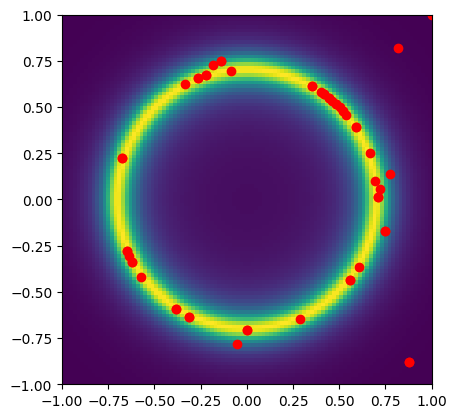

In [138]:
Z_op = f_app_op(X,Y)
Z_origin = func_test(X,Y)
plt.imshow(Z_origin.max()*Z_op/np.abs(Z_op).max(), extent=(-1,1,-1,1))
plt.scatter(*pivots.T, c="r")
print(Z_op.max(), Z_op.min())
print(Z_origin.max(), Z_origin.min())

In [108]:
Z[60, 14]

0.06267668658046621

In [109]:
x,y = X[60,14], Y[60, 14]

In [110]:
func_test(x,y)

0.7396378774580799

0.09375775811867593


/var/folders/wv/cwvgxcp14lxcs5jn0r6p87sr0000gn/T/ipykernel_21223/525479811.py:24: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  fx_v = np.vstack(f(x) for f in self.func_x)
/var/folders/wv/cwvgxcp14lxcs5jn0r6p87sr0000gn/T/ipykernel_21223/525479811.py:25: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  fy_v = np.vstack(f(y) for f in self.func_y)


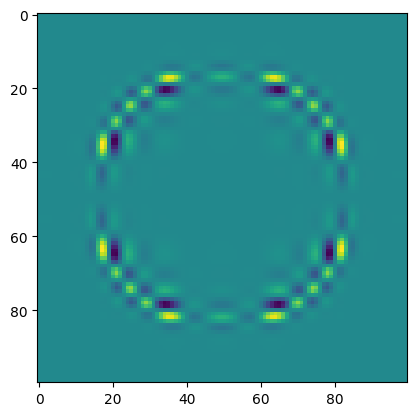

In [116]:
Z = func_test(X,Y)-f_app_op(X,Y)
print(np.abs(Z).max())
plt.imshow(Z)

The problem of einsum class is 
elimination process cannot reach the double precison.

Try nexts:

1. Convolution routine replace `scipy.signal.convolve2d`.
2. Using ChebyShev instead of `partial` routine. 